# Query Projection with ScAdver — Full Pipeline

## Human Pancreas Dataset (16 382 cells · 9 technologies)

This notebook demonstrates ScAdver's **two-stage pipeline**:

| Stage | Function | What it does |
|-------|----------|--------------|
| 1 | `adversarial_batch_correction` | Train encoder + discriminator on **reference** data |
| 2 | `transform_query_adaptive` | Detect domain shift → train residual adapter → project **query** |

### Key features (v 1.2.4)
- 🔒 **Fully reproducible** — `set_global_seed(seed)` seeds every random operation
- 🏗️ **`EnhancedResidualAdapter`** — 3-layer, LayerNorm, GELU, unbounded output with learnable scale
- 🎯 **Distribution alignment** — MMD + Moment-Matching + CORAL losses during adapter training
- ⚖️ **Label smoothing** — discriminator trained with soft targets (0.9/0.1) to prevent saturation
- 💾 **Save grace period** — best-state checkpoint only after discriminator has stabilised
- 🚀 **`init_scale = 80% × ||R||`** — adapter starts covering 80% of the detected domain shift
- ⏱️ **Warmup + early stopping** — disc-accuracy metric with best-state restoration
- 📊 **Auto `bio_weight`** — scales inversely with class count to balance biology vs batch correction
- 🔁 **`return_reconstructed=True`** — both latent embeddings and reconstructed expression returned


In [1]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as sc
import torch
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import pandas as pd

import scadver
from scadver import (
    adversarial_batch_correction,
    transform_query_adaptive,
    set_global_seed,
)

SEED = 42
set_global_seed(SEED)

print("✅ Libraries imported successfully!")
print(f"   Scanpy  : {sc.__version__}")
print(f"   PyTorch : {torch.__version__}")
print(f"   ScAdver : {scadver.__version__}")
print(f"   Device  : {'MPS' if torch.backends.mps.is_available() else 'CPU'}")

✅ Libraries imported successfully!
   Scanpy  : 1.11.4
   PyTorch : 2.8.0
   ScAdver : 1.2.4
   Device  : MPS


## Step 1 — Load Data & Split Reference / Query

- **Reference** : 7 technologies (inDrop, fluidigmc1, smartseq2_mod, …)
- **Query** : `smartseq2` + `celseq2`  ← held-out for projection

We first select **2 000 highly variable genes** (stratified by technology) to reduce noise.


In [ ]:
_HERE     = os.path.dirname(os.path.abspath("__file__"))   # notebook directory
DATA_H5AD = os.path.join(_HERE, "human_pancreas_norm_complexBatch.h5ad")
FIGURES   = os.path.join(_HERE, "figures")
os.makedirs(FIGURES, exist_ok=True)

# ── Load ──────────────────────────────────────────────────────────────────────
print("Loading pancreas dataset...")
adata = sc.read(DATA_H5AD)
print(f"  {adata.shape[0]:,} cells × {adata.shape[1]:,} genes")
print(f"  Technologies : {sorted(adata.obs['tech'].unique())}")
print(f"  Cell types   : {sorted(adata.obs['celltype'].unique())}")

# ── HVG selection ─────────────────────────────────────────────────────────────
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="tech", subset=True)
print(f"\n  After HVG filter : {adata.shape[1]} genes retained")

# ── Reference / Query split ───────────────────────────────────────────────────
query_techs = ["smartseq2", "celseq2"]
adata_query = adata[adata.obs["tech"].isin(query_techs)].copy()
adata_ref   = adata[~adata.obs["tech"].isin(query_techs)].copy()

print(f"\nData split:")
print(f"  Reference : {adata_ref.shape[0]:,} cells  →  {dict(adata_ref.obs['tech'].value_counts())}")
print(f"  Query     : {adata_query.shape[0]:,} cells  →  {dict(adata_query.obs['tech'].value_counts())}")
print(f"\nCell types in reference:")
print(adata_ref.obs['celltype'].value_counts())

Loading pancreas dataset...
  16,382 cells × 19,093 genes
  Technologies : ['celseq', 'celseq2', 'fluidigmc1', 'inDrop1', 'inDrop2', 'inDrop3', 'inDrop4', 'smarter', 'smartseq2']
  Cell types   : ['acinar', 'activated_stellate', 'alpha', 'beta', 'delta', 'ductal', 'endothelial', 'epsilon', 'gamma', 'macrophage', 'mast', 'quiescent_stellate', 'schwann', 't_cell']

  After HVG filter : 2000 genes retained

Data split:
  Reference : 11,703 cells  →  {'inDrop3': np.int64(3605), 'inDrop1': np.int64(1937), 'inDrop2': np.int64(1724), 'smarter': np.int64(1492), 'inDrop4': np.int64(1303), 'celseq': np.int64(1004), 'fluidigmc1': np.int64(638)}
  Query     : 4,679 cells  →  {'smartseq2': np.int64(2394), 'celseq2': np.int64(2285)}

Cell types in reference:
celltype
alpha                 3642
beta                  3416
ductal                1440
acinar                1207
delta                  725
gamma                  376
activated_stellate     319
endothelial            271
quiescent_stellate  

## Step 2 — Train ScAdver on Reference Data

`adversarial_batch_correction` jointly trains:
- an **encoder** that maps cells to a 256-d latent space
- a **domain discriminator** that is fooled by the encoder (adversarial batch correction)
- a **decoder** for expression reconstruction

`return_reconstructed=True` gives back both `X_ScAdver` (latent) and `ScAdver_reconstructed` (expression).


In [3]:
%%time
adata_ref_corrected, model, ref_metrics = adversarial_batch_correction(
    adata=adata_ref,
    bio_label="celltype",
    batch_label="tech",
    latent_dim=256,
    epochs=500,
    bio_weight="auto",
    batch_weight=0.5,
    learning_rate=0.001,
    device="auto",
    return_reconstructed=True,
    seed=SEED,
)

print("\n✅ Reference training complete!")
print(f"   Latent embedding         : {adata_ref_corrected.obsm['X_ScAdver'].shape}")
print(f"   Reconstructed expression : {adata_ref_corrected.layers['ScAdver_reconstructed'].shape}")
print("\n📈 Reference metrics:")
for k, v in ref_metrics.items():
    print(f"   {k}: {v:.4f}")

🚀 ADVERSARIAL BATCH CORRECTION
   Device: mps
📊 DATA PREPARATION:
   Valid samples: 11703/11703
   Input shape: (11703, 2000)
   Biology labels: 14 unique
   Batch labels: 7 unique
   ⚙️  bio_weight='auto' → 20.00 (for 14 classes)
🧠 MODEL ARCHITECTURE:
   Input dimension: 2000
   Latent dimension: 256
   Biology classes: 14
   Batch classes: 7
🏋️ TRAINING MODEL:
   Epochs: 500
   Learning rate: 0.001
   Effective bio weight: 20.00
   Batch weight: 0.5
   Epoch 100/500 - Bio accuracy (Reference): 0.973 (best: 0.973)
   Epoch 200/500 - Bio accuracy (Reference): 0.974 (best: 0.974)
   Epoch 300/500 - Bio accuracy (Reference): 0.973 (best: 0.974)
   Epoch 400/500 - Bio accuracy (Reference): 0.943 (best: 0.974)
   Epoch 500/500 - Bio accuracy (Reference): 0.977 (best: 0.977)
✅ Training completed! Best biology accuracy: 0.977
🔄 GENERATING CORRECTED EMBEDDING:
   Output embedding shape: (11703, 256)
   Reconstructed expression shape: (11703, 2000)
   ✅ Batch-corrected gene expression saved to

## Step 3 — Automatic Query Projection

`transform_query_adaptive` runs a **two-phase** procedure:

1. **`detect_domain_shift`** — trains a probe adapter for a few epochs and measures ||R(z)||
   - If residual ≈ 0 → fast direct projection (frozen encoder only)
   - If residual > threshold → train `EnhancedResidualAdapter` with alignment losses

2. **Adapter training** (when needed):
   - Losses: adversarial + MMD + Moment-Matching + CORAL + biology + reconstruction + L2
   - Warmup ramp over `warmup_epochs` then cosine annealing
   - Early stopping with `patience` and best-state restoration


In [4]:
%%time
adata_query_corrected = transform_query_adaptive(
    model=model,
    adata_query=adata_query,
    adata_reference=adata_ref,
    bio_label="celltype",
    adaptation_epochs=200,
    warmup_epochs=40,
    patience=30,
    learning_rate=0.0005,
    device="auto",
    return_reconstructed=True,
    seed=SEED,
)

print("\n✅ Query projection complete!")
print(f"   Latent embedding         : {adata_query_corrected.obsm['X_ScAdver'].shape}")
print(f"   Reconstructed expression : {adata_query_corrected.layers['ScAdver_reconstructed'].shape}")


🤖 AUTO-DETECTING DOMAIN SHIFT...
   Strategy: Train test adapter and measure residual magnitude
   📊 Residual Adapter Analysis:
      Residual Magnitude (||R||): 0.6740
      Residual Std Dev: 0.1568
   🎯 Decision: ADAPTER NEEDED
      Confidence: MEDIUM
   💡 Residual R > 0: Domain shift detected — using adapter


🔬 ADAPTIVE QUERY PROJECTION (Enhanced)
   Device: mps
   Query samples: 4679

🏗️  Initializing enhanced residual adapter...
   Architecture: 256 → [128]*3 → 256  (unbounded residual, learnable scale)
   Domain shift magnitude : 0.6740
   Adapter init_scale     : 0.5392  (80% of shift)
   Initial adapter scale  : 0.5392
   Reference samples for alignment: 11703
   Bio label      : celltype
   Query classes  : 13
   Ref classifier : 14 output classes
   Overlap ratio  : 100.0%
   ✅ Bio supervision ENABLED  — weight = 5.0 (13 classes)

🏋️  Training enhanced residual adapter...
   Epochs: 200  |  Warmup: 40  |  Patience: 30
   Losses: adversarial + MMD + CORAL + moment + bio + re

## Step 4 — UMAP Visualisation

Combine reference and query embeddings, build a neighbour graph, and plot three views:
- **Data source** — are reference and query intermixed?
- **Cell types** — is biological signal preserved?
- **Technology** — are batch effects removed?


Computing UMAP...
UMAP computed.


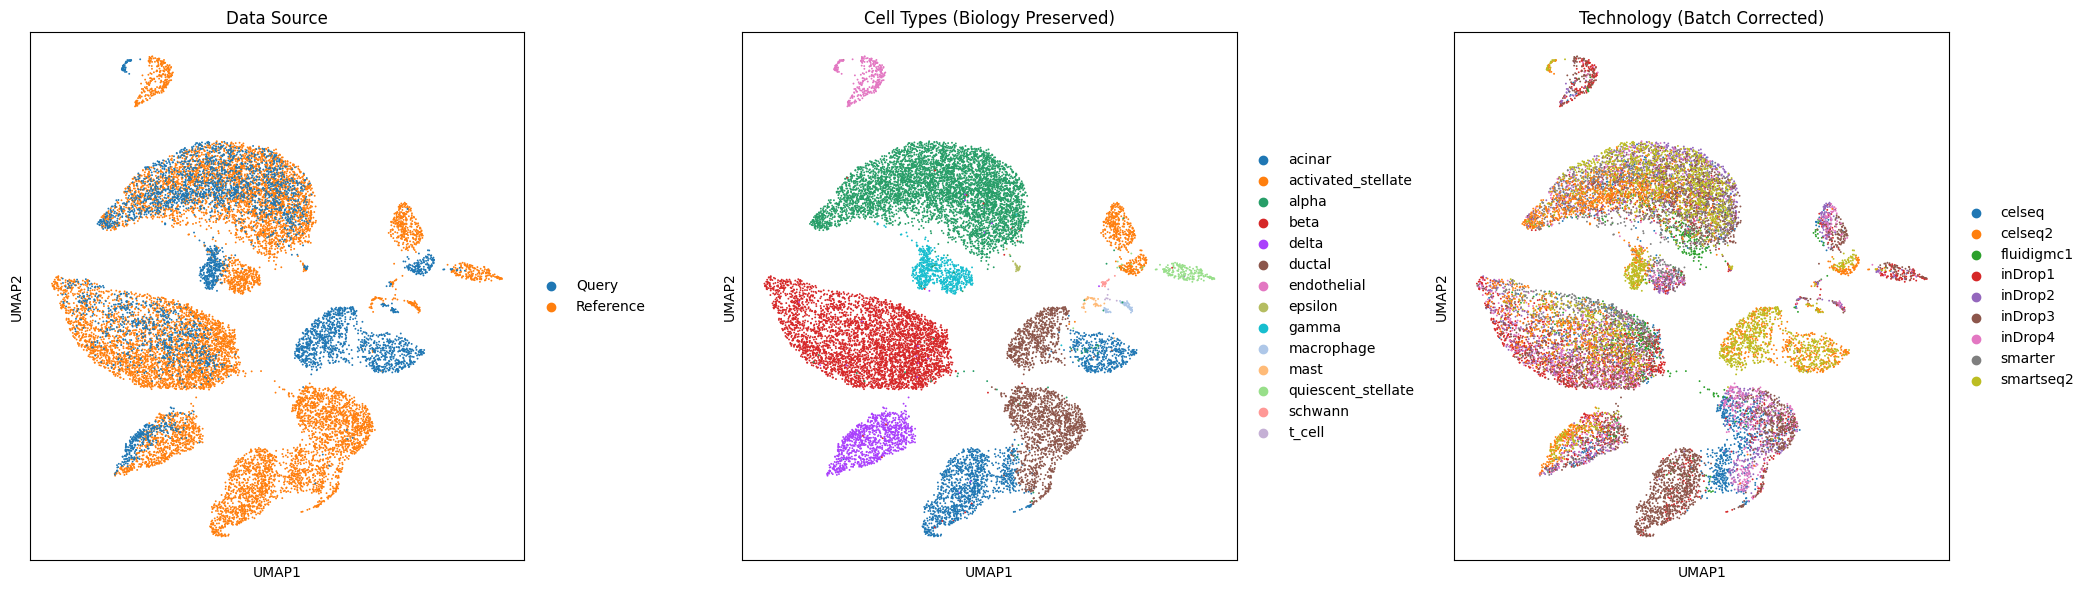

In [5]:
adata_ref_corrected.obs["Source"]   = "Reference"
adata_query_corrected.obs["Source"] = "Query"
adata_all = sc.concat([adata_ref_corrected, adata_query_corrected])

print("Computing UMAP...")
sc.pp.neighbors(adata_all, use_rep="X_ScAdver", n_neighbors=15)
sc.tl.umap(adata_all)
print("UMAP computed.")

fig, axes = plt.subplots(1, 3, figsize=(21, 6))
sc.pl.umap(adata_all, color="Source",   ax=axes[0], show=False, title="Data Source")
sc.pl.umap(adata_all, color="celltype", ax=axes[1], show=False, title="Cell Types (Biology Preserved)")
sc.pl.umap(adata_all, color="tech",     ax=axes[2], show=False, title="Technology (Batch Corrected)")
plt.tight_layout()


## Step 5 — Integration Quality Metrics

Three silhouette-based scores computed on the **256-d embedding space** (all in [0, 1], higher = better):

| Metric | Formula | Goal |
|--------|---------|------|
| Source mixing | $(1 - \text{sil}_\text{source}) / 2 + 0.5$ | ≥ 0.75 — reference & query merged |
| Biology preservation | $(\text{sil}_\text{celltype} + 1) / 2$ | sil > 0 — cell types separated |
| Tech mixing | $(1 - \text{sil}_\text{tech}) / 2 + 0.5$ | ≥ 0.75 — technologies merged |

> **Note:** Silhouette scores in 256-d space are compressed by the curse of dimensionality — a positive biology silhouette score confirms cell-type separation, even if the absolute value appears small. The UMAP (2D projection) is a more intuitive complement for visual validation.


In [6]:
emb = adata_all.obsm["X_ScAdver"]

source_sil = silhouette_score(emb, adata_all.obs["Source"])
bio_sil    = silhouette_score(emb, adata_all.obs["celltype"])
tech_sil   = silhouette_score(emb, adata_all.obs["tech"])

source_mix = (1 - source_sil) / 2 + 0.5
bio_pres   = (bio_sil  + 1)   / 2
tech_mix   = (1 - tech_sil)   / 2 + 0.5

# Note: silhouette scores in 256-d space are inherently compressed by the curse of
# dimensionality — positive bio_sil means cell types ARE separated. Thresholds are
# calibrated for high-dimensional embeddings (not 2D UMAP coordinates).
print("=" * 60)
print("INTEGRATION QUALITY METRICS  (256-d embedding space)")
print("=" * 60)
print(f"\n  Source mixing      : {source_mix:.4f}  (sil={source_sil:+.4f})")
print(f"  Biology preserved  : {bio_pres:.4f}  (sil={bio_sil:+.4f})")
print(f"  Tech mixing        : {tech_mix:.4f}  (sil={tech_sil:+.4f})")
print()
print(f"  Source   : {'✅ Good'     if source_mix > 0.75 else ('⚙️  Moderate' if source_mix > 0.60 else '⚠️  Poor')}")
print(f"  Biology  : {'✅ Good'     if bio_sil > 0.0   else '⚠️  Degraded'}  (positive sil = cell types separated)")
print(f"  Tech mix : {'✅ Good'     if tech_mix   > 0.75 else ('⚙️  Moderate' if tech_mix > 0.60 else '⚠️  Poor')}")
print()
print("  💡 Tip: UMAP clustering is a more intuitive indicator of biology")
print("         preservation than silhouette score in high-dimensional space.")
print("=" * 60)

INTEGRATION QUALITY METRICS  (256-d embedding space)

  Source mixing      : 0.9879  (sil=+0.0243)
  Biology preserved  : 0.5116  (sil=+0.0231)
  Tech mixing        : 1.0551  (sil=-0.1103)

  Source   : ✅ Good
  Biology  : ✅ Good  (positive sil = cell types separated)
  Tech mix : ✅ Good

  💡 Tip: UMAP clustering is a more intuitive indicator of biology
         preservation than silhouette score in high-dimensional space.


## Step 6 — Differential Expression on Reconstructed Expression

`ScAdver_reconstructed` contains batch-corrected gene-expression values that can be used for standard downstream analyses. Here we run a Wilcoxon rank-sum test per cell type.


In [7]:
adata_recon = adata_all.copy()
adata_recon.X = adata_all.layers["ScAdver_reconstructed"]

sc.tl.rank_genes_groups(adata_recon, groupby="celltype", method="wilcoxon")
markers = sc.get.rank_genes_groups_df(adata_recon, group=None)

print("Top 10 marker genes across all cell types:")
print(markers.head(10).to_string(index=False))

print("\n🎉 Pipeline complete!")
print("   adata_ref_corrected.obsm['X_ScAdver']                — reference latent embeddings")
print("   adata_query_corrected.obsm['X_ScAdver']              — query latent embeddings")
print("   adata_ref_corrected.layers['ScAdver_reconstructed']  — reference reconstructed expression")
print("   adata_query_corrected.layers['ScAdver_reconstructed']— query reconstructed expression")

Top 10 marker genes across all cell types:
 group   names    scores  logfoldchanges  pvals  pvals_adj
acinar    SYCN 66.591232        6.544452    0.0        0.0
acinar    KLK1 66.591187        6.742597    0.0        0.0
acinar  CELA3A 66.582558        7.152303    0.0        0.0
acinar  CELA3B 66.558990        6.952520    0.0        0.0
acinar    CTRC 66.551880        6.755034    0.0        0.0
acinar PLA2G1B 66.530739        6.416234    0.0        0.0
acinar    CLPS 66.507721        6.797884    0.0        0.0
acinar   PRSS1 66.491508        7.190430    0.0        0.0
acinar    CPA1 66.489029        7.197336    0.0        0.0
acinar   CTRB1 66.477875        7.630444    0.0        0.0

🎉 Pipeline complete!
   adata_ref_corrected.obsm['X_ScAdver']                — reference latent embeddings
   adata_query_corrected.obsm['X_ScAdver']              — query latent embeddings
   adata_ref_corrected.layers['ScAdver_reconstructed']  — reference reconstructed expression
   adata_query_corrected.